# Model 4: CNNs-SVM-with-Aug

## 6-Layer CNN + SVM Classifier

**Architecture:** CNN feature extractor + SVM with L2 regularization
- Input: 224×224×3
- Epochs: 20, Batch: 32
- Loss: squared_hinge

**Target:** 99.14% accuracy

In [ ]:
%run 00_utils_and_config.ipynb

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda
Configuration loaded successfully!

Base path: C:\Users\rishi\CV_Assignment\Paper2
Raw data path: C:\Users\rishi\CV_Assignment\Paper2\Raw_Data
Number of models: 5
Data processing functions loaded successfully!
Evaluation metrics functions loaded successfully!
Visualization functions loaded successfully!
Data augmentation setup loaded successfully!

PAPER 2 UTILITIES AND CONFIGURATION - SUMMARY

✓ All libraries imported successfully
✓ Configuration parameters loaded
✓ Data processing functions defined
✓ Evaluation metrics functions defined
✓ Visualization functions defined
✓ Data augmentation configured

Ready to proceed with:
  - Notebook 01: Data Preparation
  - Notebooks 02-06: Model Implementations
  - Notebook 07: Results Comparison



: 

In [3]:
X_train = np.load(CONFIG["processed_data_path"] / "X_train_224.npy").astype("float32") / 255.0
X_test = np.load(CONFIG["processed_data_path"] / "X_test_224.npy").astype("float32") / 255.0
y_train = np.load(CONFIG["processed_data_path"] / "y_train.npy")
y_test = np.load(CONFIG["processed_data_path"] / "y_test.npy")

# Convert to PyTorch format
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

## Build CNN-SVM

In [4]:
class CNNSVM(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super(CNNSVM, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten_size = 32 * 56 * 56  # 224->112->56
        self.fc = nn.Linear(self.flatten_size, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.flatten_size)
        x = self.fc(x)
        return x

model = CNNSVM(input_channels=3, num_classes=2).to(device)
criterion = nn.MultiMarginLoss()  # SVM-like loss
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)  # L2 regularization
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

CNNSVM(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)
Total parameters: 220,962


## Train

In [5]:
train_transforms, test_transforms = create_data_augmentation()
train_dataset = AugmentedDataset(X_train, y_train, transform=train_transforms)
test_dataset = AugmentedDataset(X_test, y_test, transform=test_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

start_time = time.time()
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_path = str(CONFIG["saved_models_path"] / "model4_cnn_svm_best.pth")

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
    
    print(f"Epoch {epoch+1}/20 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

training_time = time.time() - start_time

Epoch 1/20 - Loss: 0.4586, Acc: 0.5508, Val Acc: 0.5512
Epoch 2/20 - Loss: 0.4515, Acc: 0.5508, Val Acc: 0.5512
Epoch 3/20 - Loss: 0.4535, Acc: 0.5512, Val Acc: 0.5512
Epoch 4/20 - Loss: 0.4466, Acc: 0.5512, Val Acc: 0.5512
Epoch 5/20 - Loss: 0.4497, Acc: 0.5503, Val Acc: 0.5512
Epoch 6/20 - Loss: 0.4506, Acc: 0.5521, Val Acc: 0.5512
Epoch 7/20 - Loss: 0.4462, Acc: 0.5544, Val Acc: 0.5548
Epoch 8/20 - Loss: 0.4475, Acc: 0.5540, Val Acc: 0.5567
Epoch 9/20 - Loss: 0.4467, Acc: 0.5530, Val Acc: 0.5521
Epoch 10/20 - Loss: 0.4474, Acc: 0.5572, Val Acc: 0.5521
Epoch 11/20 - Loss: 0.4446, Acc: 0.5565, Val Acc: 0.5521
Epoch 12/20 - Loss: 0.4467, Acc: 0.5562, Val Acc: 0.5512
Epoch 13/20 - Loss: 0.4451, Acc: 0.5572, Val Acc: 0.5567
Epoch 14/20 - Loss: 0.4485, Acc: 0.5608, Val Acc: 0.5521
Epoch 15/20 - Loss: 0.4465, Acc: 0.5574, Val Acc: 0.5567
Epoch 16/20 - Loss: 0.4458, Acc: 0.5610, Val Acc: 0.5576
Epoch 17/20 - Loss: 0.4471, Acc: 0.5521, Val Acc: 0.5567
Epoch 18/20 - Loss: 0.4474, Acc: 0.5560,

## Evaluate

In [6]:
best_model = CNNSVM(input_channels=3, num_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

all_preds, all_probs = [], []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())

y_pred_proba = np.vstack(all_probs)
y_pred = np.concatenate(all_preds)
metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba[:, 1])
print_metrics(metrics, "Model 4: CNN-SVM")
print(f"Accuracy: {metrics['accuracy']*100:.2f}% (Target: 99.14%)")


Model 4: CNN-SVM - Evaluation Metrics
Accuracy:    56.31%
Precision:   84.21%
Recall:      3.26%
F1-Score:    6.27%
Specificity: 99.50%
AUC:         0.6374

Confusion Matrix:
  TN=600, FP=3
  FN=475, TP=16

Accuracy: 56.31% (Target: 99.14%)


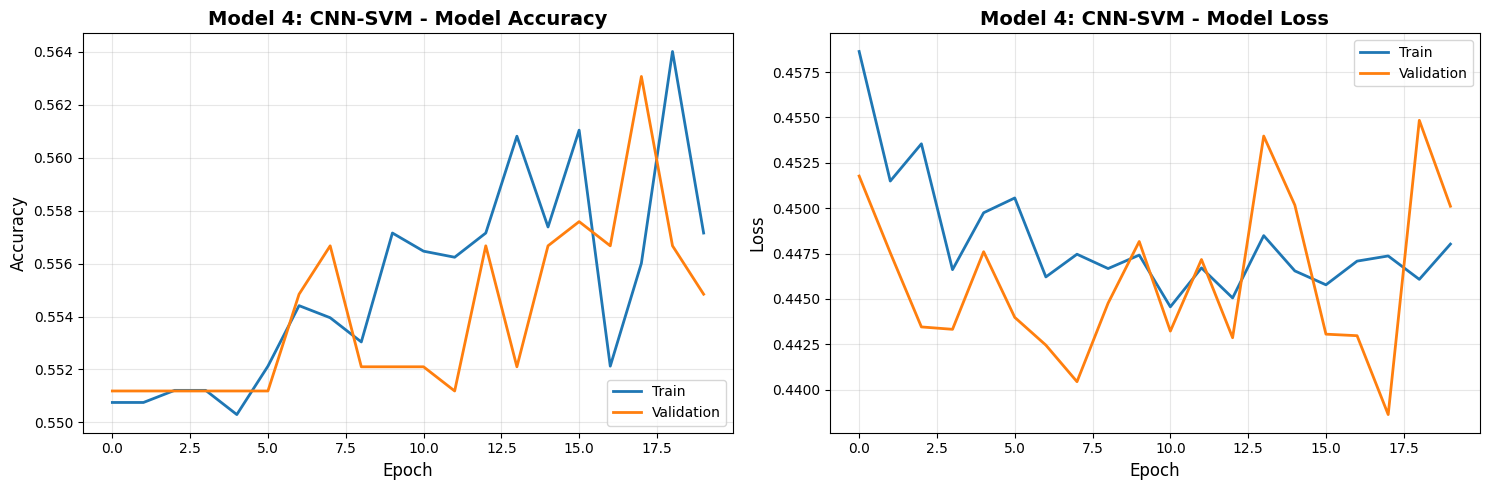

✓ Model 4 saved


In [7]:
plot_training_history(history, "Model 4: CNN-SVM", CONFIG["results_path"] / "training_curves" / "model4_training.png")
torch.save(model.state_dict(), CONFIG["saved_models_path"] / "model4_cnn_svm_final.pth")
results = {"model_name": "CNN-SVM-with-Aug", "accuracy": float(metrics["accuracy"]), "precision": float(metrics["precision"]), "recall": float(metrics["recall"]), "f1_score": float(metrics["f1_score"])}
with open(CONFIG["results_path"] / "model4_results.json", "w") as f: json.dump(results, f, indent=2)
print("✓ Model 4 saved")